# ML Models Using GPR and TRC SF 401

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import scipy.stats

# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import statsmodels.api as sms

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# Support Vector Regression
from sklearn.svm import SVR

# KNN
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 

# ANN Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
# ANN MLP
from sklearn.neural_network import MLPRegressor

from utils import paths

%matplotlib inline

#####ADDED TO SUPPRESS WARNINGS
import warnings
warnings.filterwarnings("ignore")
#####ADDED TO SUPPRESS WARNINGS


In [10]:
# Global variables
FeatureFile = '.\Data\SF401OUT_V2.xlsx'
random_state = 1234 

In [11]:
# Read feature file
featureDF_all = pd.read_pickle(paths.TRC_ML+"/C138.csv")

# Drop rows with Nan
featureDF = featureDF_all.dropna()

#featureDF

## Initial Model Params

In [4]:
## The following columns are not included as features
# METRAGE = not a predictor of defect
# Start Km = not a predictor of defect
# End Km = not a predictor of defect
# SDTopLeft4 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# SDTopRight4 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# SDTwist104 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# SDTwist34 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# SDVersL4 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# SDVersR4 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# Combined1 = derived from other predictors (eg SDTwist3)
# Combined2 = derived from other predictors (eg SDTwist3)
# Combined3 = derived from other predictors (eg SDTwist3)
# Combined4 = response

## The following are predictors
# PVCLeft
# PVCCentre
# PVCRight
# LRILeft
# LRICentre
# LRIRight
# BTILeft
# BTICentre
# BTIRight
# MLILeft
# MLICentre
# MLIRight
# SMLILeft
# SMLICentre
# SMLIRight
# FDLLeft
# FDLCentre
# FDLRight
# CTQILeft
# CTQICentre
# CTQIRight
# BVMLeftVolume
# BVMLeftCategory
# BVMCentreVolume
# BVMCentreCategory
# BVMRightVolume
# BVMRightCategory
# SMI
# SDTopLeft1
# SDTopLeft2
# SDTopLeft3
# SDTopRight1
# SDTopRight2
# SDTopRight3
# SDTwist101
# SDTwist102
# SDTwist103
# SDTwist31
# SDTwist32
# SDTwist33
# SDVersL1
# SDVersL2
# SDVersL3
# SDVersR1
# SDVersR2
# SDVersR3

## Response variable
# Combined4 = response


In [15]:
# Create train and test datsets
dates = featureDF.columns.values
sorted_dates = sorted(dates, key=lambda d:tuple(map(int, d.split('-'))))
test_proportion = 0.25
nSamples = featureDF.shape[0] # number of observations
non_features = ['METRAGE', 'Start Km', 'End Km', 'SDTopLeft4', 'SDTopRight4', 'Combined1','SDTwist104', 
                'SDTwist34','SDVersL4', 'SDVersR4', 'Combined1', 'Combined2', 'Combined3', 'Combined4']

indices = range(nSamples)
response_variable = sorted_dates[-1]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(featureDF, featureDF[response_variable],
                            indices, test_size=test_proportion, random_state = random_state)

# print(X_test)


X_train = X_train.drop(response_variable, axis=1)
X_test = X_test.drop(response_variable, axis=1)
nFeatures = X_train.shape[1] # number of features

# For use in cross validation - do not split training and test
X = featureDF.drop(response_variable, axis=1)
y = featureDF[response_variable]

# Get mean of y_test for model assessment
y_test_mean = np.mean(y_test)

# Normalise features
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)


### Linear Regression 


#### Not Normalised

In [17]:
# Create linear regression model
LRmodel = LinearRegression(fit_intercept = True, normalize = False)
LRmodel.fit(X_train, y_train)

r2 = LRmodel.score(X_train, y_train)
print('Coefficient of determination:', round(r2,4))

# Generate predictions and assess accuracy
LR_pred = LRmodel.predict(X_test)
LRerrors = abs(LR_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
LRmape = 100 * (LRerrors / y_test).replace([np.inf, -np.inf])
LRaccuracy = 100 - np.mean(LRmape)
print('LR accuracy:', round(LRaccuracy, 2), '%.')

# Obtain coefficients
coeff_df = pd.DataFrame(LRmodel.coef_, X_train.columns, columns=['Coefficient'])  
coeff_df

Coefficient of determination: 0.9285
LR accuracy: 98.1 %.


,Coefficient
2014-01-31,0.050761
2014-02-11,-0.054302
2014-02-14,0.004622
2014-05-16,-0.084217
2014-06-04,0.089277
2014-10-04,0.054817
2014-10-31,-0.057435
2015-01-20,-0.006771
2015-02-05,0.003811
2015-02-06,0.000072


#### Normalised

In [18]:
# Create linear regression model
LRmodel_scaled = LinearRegression(fit_intercept = True, normalize = True)
LRmodel_scaled.fit(X_train_scaled, y_train)

r2 = LRmodel_scaled.score(X_train_scaled, y_train)
print('LR coefficient of determination:', round(r2,4))

# Generate predictions and assess accuracy
LR_pred_scaled = LRmodel_scaled.predict(X_test_scaled)
LRerrors = abs(LR_pred_scaled - y_test)

# Calculate mean absolute percentage error (MAPE)
LRmape = 100 * (LRerrors / y_test).replace([np.inf, -np.inf])
LRaccuracy = 100 - np.mean(LRmape)
print('LR accuracy:', round(LRaccuracy, 2), '%.')

LR coefficient of determination: 0.9285
LR accuracy: 98.68 %.


#### Plot predicted vs. actual

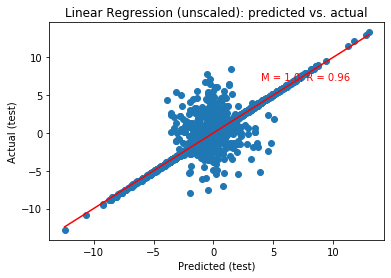

In [19]:
plt.scatter(LR_pred, y_test)
plt.title('Linear Regression (unscaled): predicted vs. actual', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(LR_pred), np.poly1d(np.polyfit(LR_pred, y_test, 1))(np.unique(LR_pred)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(LR_pred, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

In [20]:
# Rerun using OLS to obtain P-values
X_train_features = sms.add_constant(X_train) # Ensure an intercept is provided
OLSmodel = sms.OLS(y_train, X_train)
OLSresults = OLSmodel.fit()
print(OLSresults.summary())

                                 OLS Regression Results                                
Dep. Variable:             2019-03-04   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              8259.
Date:                Sun, 17 Nov 2019   Prob (F-statistic):                        0.00
Time:                        15:14:59   Log-Likelihood:                         -24788.
No. Observations:               29959   AIC:                                  4.967e+04
Df Residuals:                   29912   BIC:                                  5.006e+04
Df Model:                          47                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Cross validation score all features

In [21]:
# Cross Validation
k_folds = 10
LRmodel_scaled_CV = LinearRegression(fit_intercept = True, normalize = True)
LRmodel_scaled_CV.fit(X_scaled, y)

LRscores = cross_val_score(LRmodel_scaled_CV, X=X_scaled, y=y, cv=k_folds)
print('LR',k_folds,'fold CV average score:', round(np.mean(LRscores)*100,2),'%')

LR 10 fold CV average score: 91.41 %


#### LASSO

In [23]:
# Vary alpha to optimise LASSO NB alpha=0 = OLS
alpha_array = [1e-6, 1e-5, 0.0001, 0.01, 0.1, 0.5, 1.0, 5.0, 10, 50, 100]
LASSO_array = [] # array will store alpha, test accuracy, test score and # params

for alpha_iter in alpha_array:
    print('\nalpha:', alpha_iter)
    
    # Create LASSO model
    LASSOmodel = linear_model.Lasso(alpha=alpha_iter, max_iter=10e5)
    LASSOmodel.fit(X_train, y_train)
    LASSOtrain_score = LASSOmodel.score(X_train, y_train)

    # Generate predictions and assess accuracy
    LASSO_pred = LASSOmodel.predict(X_test)
    LASSOerrors = abs(LASSO_pred - y_test)

    # Calculate mean absolute percentage error (MAPE)
    LASSOmape = 100 * (LASSOerrors / y_test).replace([np.inf, -np.inf])
    LASSOaccuracy = 100 - np.mean(LASSOmape)
    print('LASSO accuracy:', round(LASSOaccuracy, 2), '%.')

    # Obtain test score
    LASSOtest_score = LASSOmodel.score(X_test, y_test)
    LASSOcoeff_used = np.sum(LASSOmodel.coef_!=0)
    print('LASSO test score:', round(LASSOtest_score, 3))
    print('LASSO coefficients used:', LASSOcoeff_used)
    LASSO_array.append([alpha_iter, LASSOaccuracy, LASSOtest_score, LASSOcoeff_used])

LASSO_array = np.asarray(LASSO_array)    


alpha: 1e-06
LASSO accuracy: 98.1 %.
LASSO test score: 0.914
LASSO coefficients used: 47

alpha: 1e-05
LASSO accuracy: 98.1 %.
LASSO test score: 0.914
LASSO coefficients used: 47

alpha: 0.0001
LASSO accuracy: 98.1 %.
LASSO test score: 0.914
LASSO coefficients used: 46

alpha: 0.01
LASSO accuracy: 98.18 %.
LASSO test score: 0.91
LASSO coefficients used: 29

alpha: 0.1
LASSO accuracy: 99.43 %.
LASSO test score: 0.901
LASSO coefficients used: 1

alpha: 0.5
LASSO accuracy: 100.0 %.
LASSO test score: 0.889
LASSO coefficients used: 1

alpha: 1.0
LASSO accuracy: 99.8 %.
LASSO test score: 0.849
LASSO coefficients used: 1

alpha: 5.0
LASSO accuracy: 97.65 %.
LASSO test score: -0.0
LASSO coefficients used: 0

alpha: 10
LASSO accuracy: 97.65 %.
LASSO test score: -0.0
LASSO coefficients used: 0

alpha: 50
LASSO accuracy: 97.65 %.
LASSO test score: -0.0
LASSO coefficients used: 0

alpha: 100
LASSO accuracy: 97.65 %.
LASSO test score: -0.0
LASSO coefficients used: 0


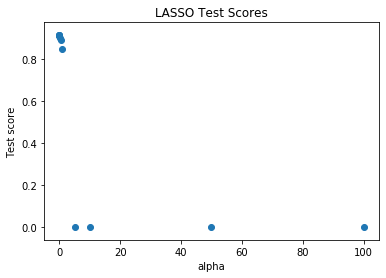

In [25]:
# Plot alpha vs test scores
plt.scatter(LASSO_array[:,0], LASSO_array[:,2])
plt.title('LASSO Test Scores', fontsize=12)
plt.xlabel('alpha', fontsize=10)
plt.ylabel('Test score', fontsize=10)
plt.show()

In [26]:
# Consider optimal alpha as test accuracy x test score
LASSO_optimal_index = np.where(LASSO_array[:,1]*LASSO_array[:,2] ==np.max(LASSO_array[:,1]*LASSO_array[:,2]))[0][0]
LASSO_optimal_alpha = LASSO_array[LASSO_optimal_index, 0]
print('Optimal alpha based on test accuracy and score:',LASSO_optimal_alpha)

# Consider optimal alpha as test accuracy x test score / # coefficients
LASSO_min_score = 0.6 # minimum test score to qualify
LASSO_min_coef = 6 # minimum number of coefficients
LASSO_best_score = 0 # Initialise score
for LASSO_iter in range(LASSO_array.shape[0]):
        if ((LASSO_array[LASSO_iter, 2] >= LASSO_min_score) & (LASSO_array[LASSO_iter, 3] >= LASSO_min_coef)):
            LASSO_working = LASSO_array[LASSO_iter,1]*LASSO_array[LASSO_iter,2]/LASSO_array[LASSO_iter,3] 
            if (LASSO_working > LASSO_best_score):
                LASSO_best_score = LASSO_working
                LASSO_best_alpha = LASSO_array[LASSO_iter,0]
print('Optimal alpha based on test accuracy and #coefficents:',LASSO_best_alpha)

Optimal alpha based on test accuracy and score: 1e-06
Optimal alpha based on test accuracy and #coefficents: 0.01


In [27]:
# Investigate coefficients
# Using highest test score and test accuracy
LASSOmodel = linear_model.Lasso(alpha=LASSO_optimal_alpha, max_iter=10e5)
LASSOmodel.fit(X_train, y_train)
print('LASSO coefficients with alpha:', LASSO_optimal_alpha)
LASSOcoeff_used = np.sum(LASSOmodel.coef_!=0)
print('LASSO coefficients used:', LASSOcoeff_used)
print(pd.DataFrame(LASSOmodel.coef_, X_train.columns, columns=['Coefficient']))

# Generate predictions and assess accuracy
LASSO_pred = LASSOmodel.predict(X_test)


LASSO coefficients with alpha: 1e-06
LASSO coefficients used: 47
            Coefficient
2014-01-31     0.050751
2014-02-11    -0.054292
2014-02-14     0.004622
2014-05-16    -0.084206
2014-06-04     0.089266
2014-10-04     0.054808
2014-10-31    -0.057426
2015-01-20    -0.006771
2015-02-05     0.003811
2015-02-06     0.000072
2015-02-10     0.006523
2015-05-15    -0.008851
2015-05-25     0.011566
2015-10-02    -0.082388
2015-11-09     0.082900
2016-01-30     0.002175
2016-02-02     0.060354
2016-02-29    -0.061725
2016-05-16     0.003743
2016-05-30    -0.078496
2016-06-03     0.076918
2016-09-09    -0.001140
2016-09-27     0.013450
2016-10-10    -0.090097
2016-10-11     0.074448
2017-01-20     0.005782
2017-01-31    -0.002299
2017-02-09     0.004152
2017-06-22     0.001393
2017-07-04    -0.082194
2017-07-13     0.078256
2017-10-17     0.047137
2017-10-25    -0.043063
2018-01-19     0.004741
2018-01-30     0.006022
2018-02-10    -0.009920
2018-06-14    -0.000346
2018-06-19     0.142759

#### Plot predicted vs. actual

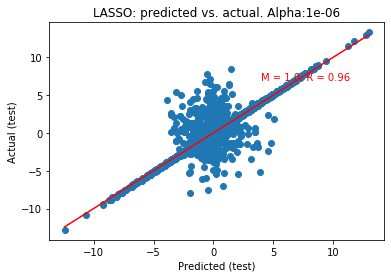

In [28]:
plt.scatter(LASSO_pred, y_test)
LASSO_title = 'LASSO: predicted vs. actual. Alpha:'+str(LASSO_optimal_alpha)
plt.title(LASSO_title, fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(LASSO_pred), np.poly1d(np.polyfit(LASSO_pred, y_test, 1))(np.unique(LASSO_pred)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(LASSO_pred, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

In [29]:
# Investigate coefficients
# Using highest test score and test accuracy / # coefficients
LASSOmodel = linear_model.Lasso(alpha=LASSO_best_alpha, max_iter=10e5)
LASSOmodel.fit(X_train, y_train)
print('\nLASSO coefficients with alpha:', LASSO_best_alpha)
LASSOcoeff_used = np.sum(LASSOmodel.coef_!=0)
print('LASSO coefficients used:', LASSOcoeff_used)
print(pd.DataFrame(LASSOmodel.coef_, X_train.columns, columns=['Coefficient']))

# Generate predictions and assess accuracy
LASSO_pred = LASSOmodel.predict(X_test)



LASSO coefficients with alpha: 0.01
LASSO coefficients used: 29
            Coefficient
2014-01-31     0.000000
2014-02-11    -0.000117
2014-02-14     0.001672
2014-05-16    -0.001958
2014-06-04     0.007409
2014-10-04     0.000000
2014-10-31    -0.000717
2015-01-20    -0.004864
2015-02-05     0.002365
2015-02-06     0.000000
2015-02-10     0.005120
2015-05-15    -0.003646
2015-05-25     0.005478
2015-10-02    -0.025699
2015-11-09     0.026665
2016-01-30     0.000000
2016-02-02     0.000000
2016-02-29    -0.000000
2016-05-16     0.000000
2016-05-30    -0.000000
2016-06-03     0.000418
2016-09-09    -0.000000
2016-09-27    -0.000000
2016-10-10    -0.000575
2016-10-11     0.000000
2017-01-20     0.003021
2017-01-31     0.000000
2017-02-09     0.002349
2017-06-22    -0.000000
2017-07-04    -0.001916
2017-07-13     0.000000
2017-10-17     0.003175
2017-10-25    -0.000000
2018-01-19     0.002113
2018-01-30     0.003900
2018-02-10    -0.006031
2018-06-14    -0.000000
2018-06-19     0.023411

#### Plot predicted vs. actual

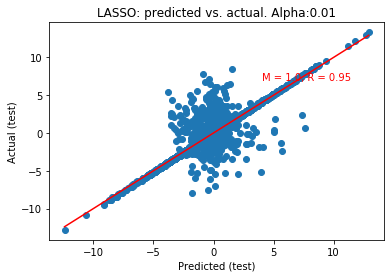

In [30]:
plt.scatter(LASSO_pred, y_test)
LASSO_title = 'LASSO: predicted vs. actual. Alpha:'+str(LASSO_best_alpha)
plt.title(LASSO_title, fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(LASSO_pred), np.poly1d(np.polyfit(LASSO_pred, y_test, 1))(np.unique(LASSO_pred)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(LASSO_pred, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

In [31]:
# Investigate coefficients
# Using alpha = 0.01
LASSOmodel = linear_model.Lasso(alpha=0.01, max_iter=10e5)
LASSOmodel.fit(X_train, y_train)
print('\nLASSO coefficients with alpha:', LASSO_best_alpha)
LASSOcoeff_used = np.sum(LASSOmodel.coef_!=0)
print('LASSO coefficients used:', LASSOcoeff_used)
print(pd.DataFrame(LASSOmodel.coef_, X_train.columns, columns=['Coefficient']))


# Generate predictions and assess accuracy
LASSO_pred = LASSOmodel.predict(X_test)


LASSO coefficients with alpha: 0.01
LASSO coefficients used: 29
            Coefficient
2014-01-31     0.000000
2014-02-11    -0.000117
2014-02-14     0.001672
2014-05-16    -0.001958
2014-06-04     0.007409
2014-10-04     0.000000
2014-10-31    -0.000717
2015-01-20    -0.004864
2015-02-05     0.002365
2015-02-06     0.000000
2015-02-10     0.005120
2015-05-15    -0.003646
2015-05-25     0.005478
2015-10-02    -0.025699
2015-11-09     0.026665
2016-01-30     0.000000
2016-02-02     0.000000
2016-02-29    -0.000000
2016-05-16     0.000000
2016-05-30    -0.000000
2016-06-03     0.000418
2016-09-09    -0.000000
2016-09-27    -0.000000
2016-10-10    -0.000575
2016-10-11     0.000000
2017-01-20     0.003021
2017-01-31     0.000000
2017-02-09     0.002349
2017-06-22    -0.000000
2017-07-04    -0.001916
2017-07-13     0.000000
2017-10-17     0.003175
2017-10-25    -0.000000
2018-01-19     0.002113
2018-01-30     0.003900
2018-02-10    -0.006031
2018-06-14    -0.000000
2018-06-19     0.023411

#### Plot pedicted vs. actual

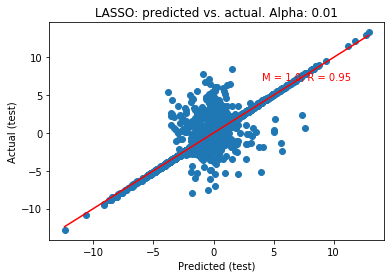

In [32]:
plt.scatter(LASSO_pred, y_test)
LASSO_title = 'LASSO: predicted vs. actual. Alpha: 0.01'
plt.title(LASSO_title, fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(LASSO_pred), np.poly1d(np.polyfit(LASSO_pred, y_test, 1))(np.unique(LASSO_pred)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(LASSO_pred, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

#### Create subset of features based on LASSO

In [33]:
# Highly reduced based on optimal alpha
# Retained some features where there was a corresponding Right/Left
LASSO_drop_features_14 = ['LRILeft', 'LRICentre', 'LRIRight', 'BTILeft', 'BTICentre', 'BTIRight',
                          'MLILeft', 'MLICentre', 'MLIRight', 'SMLILeft', 'SMLICentre', 'SMLIRight',
                          'BVMCentreVolume', 'BVMCentreCategory', 'SMI', 'SDTwist101', 'SDTwist102', 
                          'FDLLeft', 'FDLCentre', 'FDLRight', 'CTQILeft', 'CTQICentre', 'CTQIRight',
                          'BVMLeftVolume', 'BVMLeftCategory', 'BVMCentreVolume', 'BVMCentreCategory',
                          'BVMRightVolume', 'BVMRightCategory', 'SMI', 'SDTwist101', 'SDTwist102', 
                          'SDTwist31','SDVersL1', 'SDVersR1', 'SDVersR2', 'SDVersR3']
X_train_14 = X_train.drop(LASSO_drop_features_14, axis=1) 
X_test_14 = X_test.drop(LASSO_drop_features_14, axis=1) 
X_14 = X.drop(LASSO_drop_features_14, axis=1) 
X_train_scaled_14 = X_train_scaled.drop(LASSO_drop_features_14, axis=1) 
X_test_scaled_14 = X_test_scaled.drop(LASSO_drop_features_14, axis=1) 
X_scaled_14 = X_scaled.drop(LASSO_drop_features_14, axis=1) 

KeyError: "['LRILeft' 'LRICentre' 'LRIRight' 'BTILeft' 'BTICentre' 'BTIRight'\n 'MLILeft' 'MLICentre' 'MLIRight' 'SMLILeft' 'SMLICentre' 'SMLIRight'\n 'BVMCentreVolume' 'BVMCentreCategory' 'SMI' 'SDTwist101' 'SDTwist102'\n 'FDLLeft' 'FDLCentre' 'FDLRight' 'CTQILeft' 'CTQICentre' 'CTQIRight'\n 'BVMLeftVolume' 'BVMLeftCategory' 'BVMCentreVolume' 'BVMCentreCategory'\n 'BVMRightVolume' 'BVMRightCategory' 'SMI' 'SDTwist101' 'SDTwist102'\n 'SDTwist31' 'SDVersL1' 'SDVersR1' 'SDVersR2' 'SDVersR3'] not found in axis"

In [21]:
# Slightly reduced based on balance between performance and retaining features
LASSO_drop_features_36 = ['BVMCentreVolume', 'BVMCentreCategory', 'SMI', 'SDTwist101', 'SDTwist102', 
                          'SDTwist31', 'SDVersL1', 'SDVersR1', 'SDVersR2', 'SDVersR3']
X_train_36 = X_train.drop(LASSO_drop_features_36, axis=1) 
X_test_36 = X_test.drop(LASSO_drop_features_36, axis=1) 
X_36 = X.drop(LASSO_drop_features_36, axis=1) 
X_train_scaled_36 = X_train_scaled.drop(LASSO_drop_features_36, axis=1) 
X_test_scaled_36 = X_test_scaled.drop(LASSO_drop_features_36, axis=1) 
X_scaled_36 = X_scaled.drop(LASSO_drop_features_36, axis=1) 

#### Linear Regression Cross validation score reduced features

In [22]:
# Cross Validation
k_folds = 10
LRmodel_scaled_CV_14 = LinearRegression(fit_intercept = True, normalize = True)
LRmodel_scaled_CV_14.fit(X_scaled_14, y)

LRscores = cross_val_score(LRmodel_scaled_CV_14, X=X_scaled_14, y=y, cv=k_folds)
print('LR',k_folds,'fold CV average score:', round(np.mean(LRscores)*100,2),'%')

LR 10 fold CV average score: 63.38 %


#### Elastic Net

In [23]:
ENmodel = linear_model.ElasticNet(random_state = random_state)
ENmodel.fit(X_train, y_train) 
ENsearch = GridSearchCV(estimator=ENmodel, 
                        param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},
                        scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)
ENsearch.fit(X_train, y_train)
print('Optimal Elastic Net paramaters:', ENsearch.best_params_)

Optimal Elastic Net paramaters: {'alpha': 0.01, 'l1_ratio': 0.2}


In [24]:
# Refit using optimal paramaters
EN_optimal_alpha = ENsearch.best_params_['alpha']
EN_optimal_l1_ratio = ENsearch.best_params_['l1_ratio']
ENmodel = linear_model.ElasticNet(alpha=EN_optimal_alpha, l1_ratio=EN_optimal_l1_ratio, random_state = random_state)
ENmodel.fit(X_train, y_train) 

# Generate predictions and assess accuracy
EN_pred =ENmodel.predict(X_test)
ENerrors = abs(EN_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
ENmape = 100 * (ENerrors / y_test)
ENaccuracy = 100 - np.mean(ENmape)
print('Elastic Net accuracy:', round(ENaccuracy, 2), '%.')

# Obtain test score
ENtest_score = ENmodel.score(X_test, y_test)
ENcoeff_used = np.sum(ENmodel.coef_!=0)
print('Elastic Net test score:', round(ENtest_score, 3))
print('Elastic Net coefficients used:', ENcoeff_used)

# Investigate coefficients used
print('\nElastic Net coefficients with alpha:', EN_optimal_alpha, 'and L1 ratio:', EN_optimal_l1_ratio)
print(pd.DataFrame(ENmodel.coef_, X_train.columns, columns=['Coefficient']))


Elastic Net accuracy: 84.84 %.
Elastic Net test score: 0.753
Elastic Net coefficients used: 37

Elastic Net coefficients with alpha: 0.01 and L1 ratio: 0.2
                   Coefficient
PVCLeft               0.000089
PVCCentre            -0.000247
PVCRight             -0.000241
LRILeft              -0.000000
LRICentre             0.020092
LRIRight              0.024266
BTILeft              -0.059212
BTICentre             0.029813
BTIRight             -0.005748
MLILeft               0.064081
MLICentre            -0.073111
MLIRight              0.000000
SMLILeft             -0.052045
SMLICentre            0.092748
SMLIRight            -0.000000
FDLLeft               0.002893
FDLCentre             0.103140
FDLRight              0.037452
CTQILeft              0.000000
CTQICentre           -0.096023
CTQIRight             0.098852
BVMLeftVolume         0.024527
BVMLeftCategory       0.072384
BVMCentreVolume      -0.000000
BVMCentreCategory    -0.000000
BVMRightVolume        0.014993
BVMRigh

#### Plot predicted vs. actual

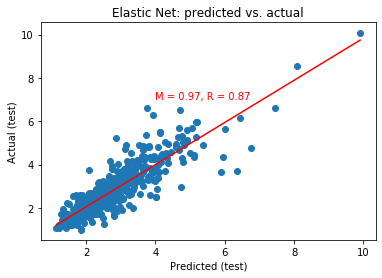

In [25]:
plt.scatter(EN_pred, y_test)
plt.title('Elastic Net: predicted vs. actual', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(EN_pred), np.poly1d(np.polyfit(EN_pred, y_test, 1))(np.unique(EN_pred)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(EN_pred, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

## Linear Regression with reduced features

#### Reduced features: 14

In [26]:
# Create linear regression model
LRmodel_scaled_14 = LinearRegression(fit_intercept = True, normalize = True)
LRmodel_scaled_14.fit(X_train_scaled_14, y_train)

r2 = LRmodel_scaled_14.score(X_train_scaled_14, y_train)
print('LR coefficient of determination (features=', X_14.shape[1],')',round(r2,4))

# Generate predictions and assess accuracy
LR_pred_scaled_14 = LRmodel_scaled_14.predict(X_test_scaled_14)
LRerrors = abs(LR_pred_scaled_14 - y_test)

# Calculate mean absolute percentage error (MAPE)
LRmape = 100 * (LRerrors / y_test)
LRaccuracy = 100 - np.mean(LRmape)
print('LR accuracy:', round(LRaccuracy, 2), '%.')

LR coefficient of determination (features= 14 ) 0.7851
LR accuracy: 84.71 %.


#### Reduced features: 36

In [27]:
# Create linear regression model
LRmodel_scaled_36 = LinearRegression(fit_intercept = True, normalize = True)
LRmodel_scaled_36.fit(X_train_scaled_36, y_train)

r2 = LRmodel_scaled_36.score(X_train_scaled_36, y_train)
print('LR coefficient of determination (features=', X_36.shape[1],')',round(r2,4))

# Generate predictions and assess accuracy
LR_pred_scaled_36 = LRmodel_scaled_36.predict(X_test_scaled_36)
LRerrors = abs(LR_pred_scaled_36 - y_test)

# Calculate mean absolute percentage error (MAPE)
LRmape = 100 * (LRerrors / y_test)
LRaccuracy = 100 - np.mean(LRmape)
print('LR accuracy:', round(LRaccuracy, 2), '%.')

LR coefficient of determination (features= 36 ) 0.8065
LR accuracy: 84.68 %.


### Random Forest Regression

#### Unscaled

In [35]:
num_trees = 1000
# Instantiate model with num_trees decision trees
RFmodel = RandomForestRegressor(n_estimators = num_trees, oob_score = True, random_state = random_state)

# Train the model on training data
RFmodel.fit(X_train, y_train)

# Generate predictions to assess performance
RF_pred = RFmodel.predict(X_test)# Calculate the absolute errors
RFerrors = abs(RF_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
RFmape = 100 * (RFerrors / y_test).replace([np.inf, -np.inf])
RFaccuracy = 100 - np.mean(RFmape)
print('RF accuracy (unscaled features):', round(RFaccuracy, 2), '%.')
RFtest_score = RFmodel.score(X_test, y_test)
print('RF test score:', round(RFtest_score, 3))
print('Out of bag score:', round(RFmodel.oob_score_,4))

RF accuracy (unscaled features): 98.28 %.
RF test score: 0.905
Out of bag score: 0.9191


#### Scaled

In [37]:
num_trees = 1000
# Instantiate model with num_trees decision trees
RFmodel = RandomForestRegressor(n_estimators = num_trees, oob_score = True, random_state = random_state)

# Train the model on training data
RFmodel.fit(X_train_scaled, y_train)

# Generate predictions to assess performance
RF_pred = RFmodel.predict(X_test_scaled)# Calculate the absolute errors
RFerrors = abs(RF_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
RFmape = 100 * (RFerrors / y_test).replace([np.inf, -np.inf])
RFaccuracy = 100 - np.mean(RFmape)
print('RF accuracy (scaled features):', round(RFaccuracy, 2), '%.')
RFtest_score = RFmodel.score(X_test_scaled, y_test)
print('RF test score:', round(RFtest_score, 3))
print('Out of bag score:', round(RFmodel.oob_score_,4))

RF accuracy (scaled features): 98.47 %.
RF test score: 0.906
Out of bag score: 0.9193


#### Cross validation score

In [38]:
# Cross Validation
num_trees = 1000
# Instantiate model with num_trees decision trees
RFmodel_CV = RandomForestRegressor(n_estimators = num_trees, oob_score = True, random_state = random_state)

# Train the model on training data
RFmodel_CV.fit(X_train, y_train)

k_folds = 10
RFscores = cross_val_score(RFmodel, X, y, cv=k_folds)
print('RF',k_folds,'fold CV average score:', round(np.mean(RFscores)*100,2),'%')

RF 10 fold CV average score: 90.29 %


#### Plot predicted and test

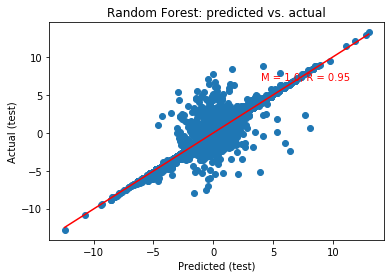

In [39]:
plt.scatter(RF_pred, y_test)
plt.title('Random Forest: predicted vs. actual', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(RF_pred), np.poly1d(np.polyfit(RF_pred, y_test, 1))(np.unique(RF_pred)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(RF_pred, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

#### RF with reduced features

In [32]:
num_trees = 1000
# Instantiate model with num_trees decision trees
RFmodel_reduced = RandomForestRegressor(n_estimators = num_trees, oob_score = True, random_state = random_state)

# Train the model on training data
RFmodel_reduced.fit(X_train_14, y_train)

# Generate predictions to assess performance
RF_pred_reduced = RFmodel_reduced.predict(X_test_14)# Calculate the absolute errors
RFerrors = abs(RF_pred_reduced - y_test)

# Calculate mean absolute percentage error (MAPE)
RFmape = 100 * (RFerrors / y_test).replace([np.inf, -np.inf])
RFaccuracy = 100 - np.mean(RFmape)
print('RF accuracy (unscaled, reduced features):', round(RFaccuracy, 2), '%.')
RFtest_score = RFmodel_reduced.score(X_test_14, y_test)
print('RF test score:', round(RFtest_score, 3))
print('Out of bag score:', round(RFmodel_reduced.oob_score_,4))

RF accuracy (unscaled, reduced features): 86.55 %.
RF test score: 0.797
Out of bag score: 0.8166


### Support Vector Regression

#### RBF Kernel

In [40]:
# Vary C to optimise SVR NB C=0 = no penalty
C_array = [0.01, 0.1, 1.0, 10, 100, 1000]
SVR_array = [] # array will store C, test accuracy and test score

for C_iter in C_array:
    print('\nC:', C_iter)

    SVRmodel = SVR(C=C_iter, kernel='rbf', gamma='auto', epsilon=0.01)
    SVRmodel.fit(X_train_scaled,y_train)

    # Generate predictions to assess performance
    SVR_pred = SVRmodel.predict(X_test_scaled)# Calculate the absolute errors
    SVRerrors = abs(SVR_pred - y_test)

    # Calculate mean absolute percentage error (MAPE)
    SVRmape = 100 * (SVRerrors / y_test).replace([np.inf, -np.inf])
    SVRaccuracy = 100 - np.mean(SVRmape)
    print('SVR accuracy:', round(SVRaccuracy, 2), '%.')
    SVRtest_score = SVRmodel.score(X_test_scaled, y_test)
    print('SVR test score:', round(SVRtest_score, 3))
    SVR_array.append([C_iter, SVRaccuracy, SVRtest_score])

SVR_array = np.asarray(SVR_array)    


C: 0.01
SVR accuracy: 97.62 %.
SVR test score: 0.606

C: 0.1
SVR accuracy: 98.38 %.
SVR test score: 0.751

C: 1.0
SVR accuracy: 98.41 %.
SVR test score: 0.866

C: 10
SVR accuracy: 98.75 %.
SVR test score: 0.903

C: 100
SVR accuracy: 98.32 %.
SVR test score: 0.9

C: 1000
SVR accuracy: 97.39 %.
SVR test score: 0.882


In [34]:
# Refit using optimal params
SVR_best_C = 10
SVR_best_epsilon = 0.01

SVRmodel = SVR(C=SVR_best_C, kernel='rbf', gamma='auto', epsilon=SVR_best_epsilon)
SVRmodel.fit(X_train_scaled,y_train)

# Generate predictions to plot predicted and actuals
SVR_pred = SVRmodel.predict(X_test_scaled)

#### Plot predicted vs. actual

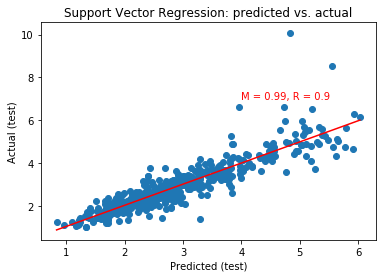

In [35]:
plt.scatter(SVR_pred, y_test)
plt.title('Support Vector Regression: predicted vs. actual', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(SVR_pred), np.poly1d(np.polyfit(SVR_pred, y_test, 1))(np.unique(SVR_pred)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(SVR_pred, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

#### Reduced features 14

In [36]:
# Refit using optimal params
SVR_best_C = 10
SVR_best_epsilon = 0.01

SVRmodel_reduced = SVR(C=SVR_best_C, kernel='rbf', gamma='auto', epsilon=SVR_best_epsilon)
SVRmodel_reduced.fit(X_train_scaled_14, y_train)

# Generate predictions to plot predicted and actuals
SVR_pred_reduced = SVRmodel_reduced.predict(X_test_scaled_14)
SVRerrors = abs(SVR_pred_reduced - y_test)

# Calculate mean absolute percentage error (MAPE)
SVRmape = 100 * (SVRerrors / y_test)
SVRaccuracy = 100 - np.mean(SVRmape)
print('SVR accuracy (features=', X_14.shape[1],'):', round(SVRaccuracy, 2), '%.')
SVRtest_score = SVRmodel_reduced.score(X_test_scaled_14, y_test)
print('SVR test score:', round(SVRtest_score, 3))

SVR accuracy (features= 14 ): 86.39 %.
SVR test score: 0.764


#### Reduced features 36

In [37]:
# Refit using optimal params
SVR_best_C = 10
SVR_best_epsilon = 0.01

SVRmodel_reduced = SVR(C=SVR_best_C, kernel='rbf', gamma='auto', epsilon=SVR_best_epsilon)
SVRmodel_reduced.fit(X_train_scaled_36, y_train)

# Generate predictions to plot predicted and actuals
SVR_pred_reduced = SVRmodel_reduced.predict(X_test_scaled_36)
SVRerrors = abs(SVR_pred_reduced - y_test)

# Calculate mean absolute percentage error (MAPE)
SVRmape = 100 * (SVRerrors / y_test)
SVRaccuracy = 100 - np.mean(SVRmape)
print('SVR accuracy (features=', X_36.shape[1],'):', round(SVRaccuracy, 2), '%.')
SVRtest_score = SVRmodel_reduced.score(X_test_scaled_36, y_test)
print('SVR test score:', round(SVRtest_score, 3))

SVR accuracy (features= 36 ): 87.98 %.
SVR test score: 0.797


#### Sigmoid Kernel

In [38]:
# Vary C to optimise SVR NB C=0 = no penalty
C_array = [0.01, 0.1, 1.0, 10, 100, 1000]
SVR_array = [] # array will store C, test accuracy and test score

for C_iter in C_array:
    print('\nC:', C_iter)

    SVRmodel = SVR(C=C_iter, kernel='sigmoid', gamma='auto', epsilon=0.01)
    SVRmodel.fit(X_train_scaled,y_train)

    # Generate predictions to assess performance
    SVR_pred = SVRmodel.predict(X_test_scaled)# Calculate the absolute errors
    SVRerrors = abs(SVR_pred - y_test)

    # Calculate mean absolute percentage error (MAPE)
    SVRmape = 100 * (SVRerrors / y_test)
    SVRaccuracy = 100 - np.mean(SVRmape)
    print('SVR accuracy:', round(SVRaccuracy, 2), '%.')
    SVRtest_score = SVRmodel.score(X_test_scaled, y_test)
    print('SVR test score:', round(SVRtest_score, 3))
    SVR_array.append([C_iter, SVRaccuracy, SVRtest_score])

SVR_array = np.asarray(SVR_array) 


C: 0.01
SVR accuracy: 80.64 %.
SVR test score: 0.594

C: 0.1
SVR accuracy: 77.85 %.
SVR test score: -0.193

C: 1.0
SVR accuracy: -60.35 %.
SVR test score: -180.0

C: 10
SVR accuracy: -1496.73 %.
SVR test score: -18649.935

C: 100
SVR accuracy: -15883.89 %.
SVR test score: -1868641.421

C: 1000
SVR accuracy: -159779.95 %.
SVR test score: -186895435.672


#### Polynomial Kernel

In [39]:
# Vary C to optimise SVR NB C=0 = no penalty
C_array = [0.01, 0.1, 1.0, 10, 100, 1000]
SVR_array = [] # array will store C, test accuracy and test score

for C_iter in C_array:
    print('\nC:', C_iter)

    SVRmodel = SVR(C=C_iter, kernel='poly', degree=3, gamma='auto', epsilon=0.1)
    SVRmodel.fit(X_train_scaled,y_train)

    # Generate predictions to assess performance
    SVR_pred = SVRmodel.predict(X_test_scaled)# Calculate the absolute errors
    SVRerrors = abs(SVR_pred - y_test)

    # Calculate mean absolute percentage error (MAPE)
    SVRmape = 100 * (SVRerrors / y_test)
    SVRaccuracy = 100 - np.mean(SVRmape)
    print('SVR accuracy:', round(SVRaccuracy, 2), '%.')
    SVRtest_score = SVRmodel.score(X_test_scaled, y_test)
    print('SVR test score:', round(SVRtest_score, 3))
    SVR_array.append([C_iter, SVRaccuracy, SVRtest_score])

SVR_array = np.asarray(SVR_array) 


C: 0.01
SVR accuracy: 73.26 %.
SVR test score: 0.323

C: 0.1
SVR accuracy: 79.01 %.
SVR test score: 0.467

C: 1.0
SVR accuracy: 83.89 %.
SVR test score: 0.513

C: 10
SVR accuracy: 83.35 %.
SVR test score: -0.593

C: 100
SVR accuracy: 80.44 %.
SVR test score: -2.144

C: 1000
SVR accuracy: 80.19 %.
SVR test score: -2.022


### Replace time-series TRC features with gradient type measure

#### Reduced features 14

In [40]:
# Replace 3 prior TRC with trend
# 
# num_TRC_periods_delta = 3
delta_decay = 0.0 # rate at which changes in periods prior to last in training set


In [41]:
# Calculate the change in TRC metrics between most recent feature (ie excluding the predictor period)
# and prior TRC periods for num_TRC_periods_delta, NB for SF401 this is only 3 periods
SDTopLeftDelta_train = (1.0*(X_train['SDTopLeft3']-X_train['SDTopLeft2'])+delta_decay*
                  (X_train['SDTopLeft2']-X_train['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_train = (1.0*(X_train['SDTopRight3']-X_train['SDTopRight2'])+delta_decay*
                   (X_train['SDTopRight2']-X_train['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_train = (1.0*(X_train['SDTwist103']-X_train['SDTwist102'])+delta_decay*
                  (X_train['SDTwist102']-X_train['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_train = (1.0*(X_train['SDTwist33']-X_train['SDTwist32'])+delta_decay*
                 (X_train['SDTwist32']-X_train['SDTwist31']))/(1+delta_decay)
SDVersLDelta_train = (1.0*(X_train['SDVersL3']-X_train['SDVersL2'])+delta_decay*
                (X_train['SDVersL2']-X_train['SDVersL1']))/(1+delta_decay)

delta_drop_features_13 = ['SDTopLeft1', 'SDTopLeft2', 'SDTopRight1', 'SDTopRight2', 'SDTwist32', 'SDVersL2']
X_train_13 = X_train_14.drop(delta_drop_features_13, axis=1)
X_train_13['SDTopLeftDelta'] = SDTopLeftDelta_train
X_train_13['SDTopRightDelta'] = SDTopRightDelta_train
X_train_13['SDTwist10Delta'] = SDTwist10Delta_train
X_train_13['SDTwist3Delta'] = SDTwist3Delta_train
X_train_13['SDVersLDelta'] = SDVersLDelta_train


In [42]:
# Test data
SDTopLeftDelta_test = (1.0*(X_test['SDTopLeft3']-X_test['SDTopLeft2'])+delta_decay*
                  (X_test['SDTopLeft2']-X_test['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_test = (1.0*(X_test['SDTopRight3']-X_test['SDTopRight2'])+delta_decay*
                   (X_test['SDTopRight2']-X_test['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_test = (1.0*(X_test['SDTwist103']-X_test['SDTwist102'])+delta_decay*
                  (X_test['SDTwist102']-X_test['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_test = (1.0*(X_test['SDTwist33']-X_test['SDTwist32'])+delta_decay*
                 (X_test['SDTwist32']-X_test['SDTwist31']))/(1+delta_decay)
SDVersLDelta_test = (1.0*(X_test['SDVersL3']-X_test['SDVersL2'])+delta_decay*
                (X_test['SDVersL2']-X_test['SDVersL1']))/(1+delta_decay)

X_test_13 = X_test_14.drop(delta_drop_features_13, axis=1)
X_test_13['SDTopLeftDelta'] = SDTopLeftDelta_test
X_test_13['SDTopRightDelta'] = SDTopRightDelta_test
X_test_13['SDTwist10Delta'] = SDTwist10Delta_test
X_test_13['SDTwist3Delta'] = SDTwist3Delta_test
X_test_13['SDVersLDelta'] = SDVersLDelta_test


In [43]:
# Train and scaled
SDTopLeftDelta_train_scaled = (1.0*(X_train_scaled['SDTopLeft3']-X_train_scaled['SDTopLeft2'])+delta_decay*
                  (X_train_scaled['SDTopLeft2']-X_train_scaled['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_train_scaled = (1.0*(X_train_scaled['SDTopRight3']-X_train_scaled['SDTopRight2'])+delta_decay*
                   (X_train_scaled['SDTopRight2']-X_train_scaled['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_train_scaled = (1.0*(X_train_scaled['SDTwist103']-X_train_scaled['SDTwist102'])+delta_decay*
                  (X_train_scaled['SDTwist102']-X_train_scaled['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_train_scaled = (1.0*(X_train_scaled['SDTwist33']-X_train_scaled['SDTwist32'])+delta_decay*
                 (X_train_scaled['SDTwist32']-X_train_scaled['SDTwist31']))/(1+delta_decay)
SDVersLDelta_train_scaled = (1.0*(X_train_scaled['SDVersL3']-X_train_scaled['SDVersL2'])+delta_decay*
                (X_train_scaled['SDVersL2']-X_train_scaled['SDVersL1']))/(1+delta_decay)

X_train_scaled_13 = X_train_scaled_14.drop(delta_drop_features_13, axis=1)
X_train_scaled_13['SDTopLeftDelta'] = SDTopLeftDelta_train_scaled
X_train_scaled_13['SDTopRightDelta'] = SDTopRightDelta_train_scaled
X_train_scaled_13['SDTwist10Delta'] = SDTwist10Delta_train_scaled
X_train_scaled_13['SDTwist3Delta'] = SDTwist3Delta_train_scaled
X_train_scaled_13['SDVersLDelta'] = SDVersLDelta_train_scaled


In [44]:
# Test and scaled
SDTopLeftDelta_test_scaled = (1.0*(X_test_scaled['SDTopLeft3']-X_test_scaled['SDTopLeft2'])+delta_decay*
                  (X_test_scaled['SDTopLeft2']-X_test_scaled['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_test_scaled = (1.0*(X_test_scaled['SDTopRight3']-X_test_scaled['SDTopRight2'])+delta_decay*
                   (X_test_scaled['SDTopRight2']-X_test_scaled['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_test_scaled = (1.0*(X_test_scaled['SDTwist103']-X_test_scaled['SDTwist102'])+delta_decay*
                  (X_test_scaled['SDTwist102']-X_test_scaled['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_test_scaled = (1.0*(X_test_scaled['SDTwist33']-X_test_scaled['SDTwist32'])+delta_decay*
                 (X_test_scaled['SDTwist32']-X_test_scaled['SDTwist31']))/(1+delta_decay)
SDVersLDelta_test_scaled = (1.0*(X_test_scaled['SDVersL3']-X_test_scaled['SDVersL2'])+delta_decay*
                (X_test_scaled['SDVersL2']-X_test_scaled['SDVersL1']))/(1+delta_decay)

X_test_scaled_13 = X_test_scaled_14.drop(delta_drop_features_13, axis=1)
X_test_scaled_13['SDTopLeftDelta'] = SDTopLeftDelta_test_scaled
X_test_scaled_13['SDTopRightDelta'] = SDTopRightDelta_test_scaled
X_test_scaled_13['SDTwist10Delta'] = SDTwist10Delta_test_scaled
X_test_scaled_13['SDTwist3Delta'] = SDTwist3Delta_test_scaled
X_test_scaled_13['SDVersLDelta'] = SDVersLDelta_test_scaled


In [45]:
# X_13
SDTopLeftDelta = (1.0*(X['SDTopLeft3']-X['SDTopLeft2'])+delta_decay*
                  (X_train['SDTopLeft2']-X['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta = (1.0*(X['SDTopRight3']-X['SDTopRight2'])+delta_decay*
                   (X['SDTopRight2']-X['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta = (1.0*(X['SDTwist103']-X['SDTwist102'])+delta_decay*
                  (X['SDTwist102']-X['SDTwist101']))/(1+delta_decay)
SDTwist3Delta = (1.0*(X['SDTwist33']-X['SDTwist32'])+delta_decay*
                 (X_train['SDTwist32']-X_train['SDTwist31']))/(1+delta_decay)
SDVersLDelta = (1.0*(X['SDVersL3']-X['SDVersL2'])+delta_decay*
                (X['SDVersL2']-X['SDVersL1']))/(1+delta_decay)

X_13 = X_36.drop(delta_drop_features_13, axis=1)
X_13['SDTopLeftDelta'] = SDTopLeftDelta
X_13['SDTopRightDelta'] = SDTopRightDelta
X_13['SDTwist10Delta'] = SDTwist10Delta
X_13['SDTwist3Delta'] = SDTwist3Delta
X_13['SDVersLDelta'] = SDVersLDelta

# X_scaled_13
SDTopLeftDelta_scaled = (1.0*(X_scaled['SDTopLeft3']-X_scaled['SDTopLeft2'])+delta_decay*
                  (X_scaled['SDTopLeft2']-X_scaled['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_scaled = (1.0*(X_scaled['SDTopRight3']-X_scaled['SDTopRight2'])+delta_decay*
                   (X_scaled['SDTopRight2']-X_scaled['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_scaled = (1.0*(X_scaled['SDTwist103']-X_scaled['SDTwist102'])+delta_decay*
                  (X_scaled['SDTwist102']-X_scaled['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_scaled = (1.0*(X_scaled['SDTwist33']-X_scaled['SDTwist32'])+delta_decay*
                 (X_scaled['SDTwist32']-X_scaled['SDTwist31']))/(1+delta_decay)
SDVersLDelta_scaled = (1.0*(X_scaled['SDVersL3']-X_scaled['SDVersL2'])+delta_decay*
                (X_scaled['SDVersL2']-X_scaled['SDVersL1']))/(1+delta_decay)

X_scaled_13 = X_scaled_14.drop(delta_drop_features_13, axis=1)
X_scaled_13['SDTopLeftDelta'] = SDTopLeftDelta_scaled
X_scaled_13['SDTopRightDelta'] = SDTopRightDelta_scaled
X_scaled_13['SDTwist10Delta'] = SDTwist10Delta_scaled
X_scaled_13['SDTwist3Delta'] = SDTwist3Delta_scaled
X_scaled_13['SDVersLDelta'] = SDVersLDelta_scaled

#### Reduced features 36

In [46]:
# Training data
delta_drop_features_35 = ['SDTopLeft1', 'SDTopLeft2', 'SDTopRight1', 'SDTopRight2', 'SDTwist32', 'SDVersL2']
X_train_35 = X_train_36.drop(delta_drop_features_35, axis=1)
X_train_35['SDTopLeftDelta'] = SDTopLeftDelta_train
X_train_35['SDTopRightDelta'] = SDTopRightDelta_train
X_train_35['SDTwist10Delta'] = SDTwist10Delta_train
X_train_35['SDTwist3Delta'] = SDTwist3Delta_train
X_train_35['SDVersLDelta'] = SDVersLDelta_train

# Testing data
X_test_35 = X_test_36.drop(delta_drop_features_35, axis=1)
X_test_35['SDTopLeftDelta'] = SDTopLeftDelta_test
X_test_35['SDTopRightDelta'] = SDTopRightDelta_test
X_test_35['SDTwist10Delta'] = SDTwist10Delta_test
X_test_35['SDTwist3Delta'] = SDTwist3Delta_test
X_test_35['SDVersLDelta'] = SDVersLDelta_test

# Train and scaled
X_train_scaled_35 = X_train_scaled_36.drop(delta_drop_features_35, axis=1)
X_train_scaled_35['SDTopLeftDelta'] = SDTopLeftDelta_train_scaled
X_train_scaled_35['SDTopRightDelta'] = SDTopRightDelta_train_scaled
X_train_scaled_35['SDTwist10Delta'] = SDTwist10Delta_train_scaled
X_train_scaled_35['SDTwist3Delta'] = SDTwist3Delta_train_scaled
X_train_scaled_35['SDVersLDelta'] = SDVersLDelta_train_scaled

# Test and scaled
X_test_scaled_35 = X_test_scaled_36.drop(delta_drop_features_35, axis=1)
X_test_scaled_35['SDTopLeftDelta'] = SDTopLeftDelta_test_scaled
X_test_scaled_35['SDTopRightDelta'] = SDTopRightDelta_test_scaled
X_test_scaled_35['SDTwist10Delta'] = SDTwist10Delta_test_scaled
X_test_scaled_35['SDTwist3Delta'] = SDTwist3Delta_test_scaled
X_test_scaled_35['SDVersLDelta'] = SDVersLDelta_test_scaled

# X_35
SDTopLeftDelta = (1.0*(X['SDTopLeft3']-X['SDTopLeft2'])+delta_decay*
                  (X_train['SDTopLeft2']-X['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta = (1.0*(X['SDTopRight3']-X['SDTopRight2'])+delta_decay*
                   (X['SDTopRight2']-X['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta = (1.0*(X['SDTwist103']-X['SDTwist102'])+delta_decay*
                  (X['SDTwist102']-X['SDTwist101']))/(1+delta_decay)
SDTwist3Delta = (1.0*(X['SDTwist33']-X['SDTwist32'])+delta_decay*
                 (X_train['SDTwist32']-X_train['SDTwist31']))/(1+delta_decay)
SDVersLDelta = (1.0*(X['SDVersL3']-X['SDVersL2'])+delta_decay*
                (X['SDVersL2']-X['SDVersL1']))/(1+delta_decay)

X_35 = X_36.drop(delta_drop_features_35, axis=1)
X_35['SDTopLeftDelta'] = SDTopLeftDelta
X_35['SDTopRightDelta'] = SDTopRightDelta
X_35['SDTwist10Delta'] = SDTwist10Delta
X_35['SDTwist3Delta'] = SDTwist3Delta
X_35['SDVersLDelta'] = SDVersLDelta

# X_scaled_35
SDTopLeftDelta_scaled = (1.0*(X_scaled['SDTopLeft3']-X_scaled['SDTopLeft2'])+delta_decay*
                  (X_scaled['SDTopLeft2']-X_scaled['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_scaled = (1.0*(X_scaled['SDTopRight3']-X_scaled['SDTopRight2'])+delta_decay*
                   (X_scaled['SDTopRight2']-X_scaled['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_scaled = (1.0*(X_scaled['SDTwist103']-X_scaled['SDTwist102'])+delta_decay*
                  (X_scaled['SDTwist102']-X_scaled['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_scaled = (1.0*(X_scaled['SDTwist33']-X_scaled['SDTwist32'])+delta_decay*
                 (X_scaled['SDTwist32']-X_scaled['SDTwist31']))/(1+delta_decay)
SDVersLDelta_scaled = (1.0*(X_scaled['SDVersL3']-X_scaled['SDVersL2'])+delta_decay*
                (X_scaled['SDVersL2']-X_scaled['SDVersL1']))/(1+delta_decay)

X_scaled_35 = X_scaled_36.drop(delta_drop_features_35, axis=1)
X_scaled_35['SDTopLeftDelta'] = SDTopLeftDelta_scaled
X_scaled_35['SDTopRightDelta'] = SDTopRightDelta_scaled
X_scaled_35['SDTwist10Delta'] = SDTwist10Delta_scaled
X_scaled_35['SDTwist3Delta'] = SDTwist3Delta_scaled
X_scaled_35['SDVersLDelta'] = SDVersLDelta_scaled


#### Random Forest using delta feature

In [47]:
# Using 35 features
num_trees = 1000
# Instantiate model with num_trees decision trees
RFmodel_reduced = RandomForestRegressor(n_estimators = num_trees, oob_score = True, random_state = random_state)

# Train the model on training data
RFmodel_reduced.fit(X_train_35, y_train)

# Generate predictions to assess performance
RF_pred_reduced = RFmodel_reduced.predict(X_test_35)# Calculate the absolute errors
RFerrors = abs(RF_pred_reduced - y_test)

# Calculate mean absolute percentage error (MAPE)
RFmape = 100 * (RFerrors / y_test)
RFaccuracy = 100 - np.mean(RFmape)
print('RF accuracy (unscaled, reduced features):', round(RFaccuracy, 2), '%.')
RFtest_score = RFmodel_reduced.score(X_test_35, y_test)
print('RF test score:', round(RFtest_score, 3))
print('Out of bag score:', round(RFmodel_reduced.oob_score_,4))

RF accuracy (unscaled, reduced features): 86.85 %.
RF test score: 0.798
Out of bag score: 0.8261


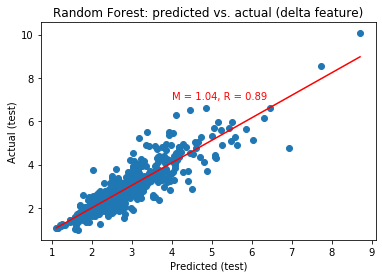

In [48]:
plt.scatter(RF_pred_reduced, y_test)
plt.title('Random Forest: predicted vs. actual (delta feature)', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(RF_pred_reduced), np.poly1d(np.polyfit(RF_pred_reduced, y_test, 1))(np.unique(RF_pred_reduced)),
         color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(RF_pred_reduced, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

In [49]:
# Using 13 features
num_trees = 1000
# Instantiate model with num_trees decision trees
RFmodel_reduced = RandomForestRegressor(n_estimators = num_trees, oob_score = True, random_state = random_state)

# Train the model on training data
RFmodel_reduced.fit(X_train_13, y_train)

# Generate predictions to assess performance
RF_pred_reduced = RFmodel_reduced.predict(X_test_13)# Calculate the absolute errors
RFerrors = abs(RF_pred_reduced - y_test)

# Calculate mean absolute percentage error (MAPE)
RFmape = 100 * (RFerrors / y_test)
RFaccuracy = 100 - np.mean(RFmape)
print('RF accuracy (unscaled, reduced features):', round(RFaccuracy, 2), '%.')
RFtest_score = RFmodel_reduced.score(X_test_13, y_test)
print('RF test score:', round(RFtest_score, 3))
print('Out of bag score:', round(RFmodel_reduced.oob_score_,4))

RF accuracy (unscaled, reduced features): 86.06 %.
RF test score: 0.779
Out of bag score: 0.8045


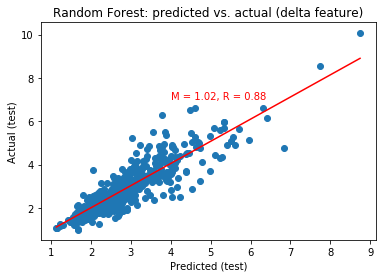

In [50]:
plt.scatter(RF_pred_reduced, y_test)
plt.title('Random Forest: predicted vs. actual (delta feature)', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(RF_pred_reduced), np.poly1d(np.polyfit(RF_pred_reduced, y_test, 1))(np.unique(RF_pred_reduced)),
         color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(RF_pred_reduced, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

#### SVR using delta feature

In [51]:
# Using 35 features
# Fit using optimal params
SVR_best_C = 10
SVR_best_epsilon = 0.01

SVRmodel_reduced = SVR(C=SVR_best_C, kernel='rbf', gamma='auto', epsilon=SVR_best_epsilon)
SVRmodel_reduced.fit(X_train_scaled_35, y_train)

# Generate predictions to plot predicted and actuals
SVR_pred_reduced = SVRmodel_reduced.predict(X_test_scaled_35)
SVRerrors = abs(SVR_pred_reduced - y_test)

# Calculate mean absolute percentage error (MAPE)
SVRmape = 100 * (SVRerrors / y_test)
SVRaccuracy = 100 - np.mean(SVRmape)
print('SVR accuracy (features=', X_train_scaled_35.shape[1],'):', round(SVRaccuracy, 2), '%.')
SVRtest_score = SVRmodel_reduced.score(X_test_scaled_35, y_test)
print('SVR test score:', round(SVRtest_score, 3))

SVR accuracy (features= 35 ): 88.02 %.
SVR test score: 0.79


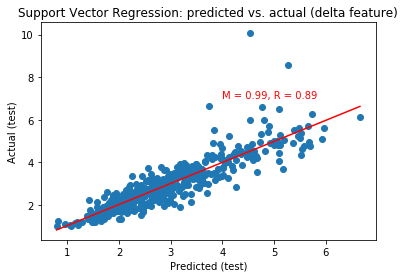

In [52]:
plt.scatter(SVR_pred_reduced, y_test)
plt.title('Support Vector Regression: predicted vs. actual (delta feature)', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(SVR_pred_reduced), np.poly1d(np.polyfit(SVR_pred_reduced, y_test, 1))(np.unique(SVR_pred_reduced)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(SVR_pred_reduced, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

In [53]:
# Using 13 features
# Fit using optimal params
SVR_best_C = 10
SVR_best_epsilon = 0.01

SVRmodel_reduced = SVR(C=SVR_best_C, kernel='rbf', gamma='auto', epsilon=SVR_best_epsilon)
SVRmodel_reduced.fit(X_train_scaled_13, y_train)

# Generate predictions to plot predicted and actuals
SVR_pred_reduced = SVRmodel_reduced.predict(X_test_scaled_13)
SVRerrors = abs(SVR_pred_reduced - y_test)

# Calculate mean absolute percentage error (MAPE)
SVRmape = 100 * (SVRerrors / y_test)
SVRaccuracy = 100 - np.mean(SVRmape)
print('SVR accuracy (features=', X_train_scaled_13.shape[1],'):', round(SVRaccuracy, 2), '%.')
SVRtest_score = SVRmodel_reduced.score(X_test_scaled_13, y_test)
print('SVR test score:', round(SVRtest_score, 3))

SVR accuracy (features= 13 ): 86.14 %.
SVR test score: 0.731


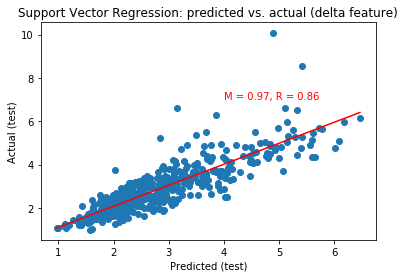

In [54]:
plt.scatter(SVR_pred_reduced, y_test)
plt.title('Support Vector Regression: predicted vs. actual (delta feature)', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(SVR_pred_reduced), np.poly1d(np.polyfit(SVR_pred_reduced, y_test, 1))(np.unique(SVR_pred_reduced)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(SVR_pred_reduced, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

### KNN

#### NB given use of distance metrics, KNN must use scaled data

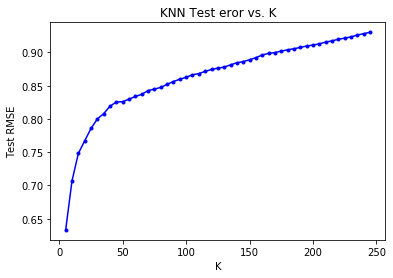

In [55]:
KNNrmse_array = [] #to store rmse values for different k
K_min = 5 # Min K value
K_max = 250 # Max K value
K_inc = 5 # Increment in K search

for K in range(K_min, K_max, K_inc):
    KNNmodel_35 = neighbors.KNeighborsRegressor(n_neighbors = K)

    KNNmodel_35.fit(X_train_scaled_35, y_train)  #fit the model
    KNNpred_35 = KNNmodel_35.predict(X_test_scaled_35) #make prediction on test set
    KNNrmse = (mean_squared_error(y_test, KNNpred_35))**0.5 #calculate rmse
    KNNrmse_array.append([K,KNNrmse]) #store rmse values

# Plot RMSE vs. K
KNNelbow = pd.DataFrame(KNNrmse_array) #elbow curve 
plt.plot(KNNelbow.loc[:,0], KNNelbow.loc[:,1], '.b-')
plt.title('KNN Test eror vs. K')
plt.xlabel('K')
plt.ylabel('Test RMSE')
ax = plt.gca()
plt.show()


In [56]:
# Extract optimal K
KNN_opt_ix = KNNelbow.loc[:,1].idxmin(axis=1)
K_opt = KNNelbow.iloc[KNN_opt_ix, 0]

# Refit using optimal K
KNNmodel_35 = neighbors.KNeighborsRegressor(n_neighbors = K_opt)

KNNmodel_35.fit(X_train_scaled_35, y_train)  #fit the model

# Generate predictions to plot predicted and actuals
KNN_pred_35 = KNNmodel_35.predict(X_test_scaled_35)
KNNerrors_35 = abs(KNN_pred_35 - y_test)

# Calculate mean absolute percentage error (MAPE)
KNNmape_35 = 100 * (KNNerrors_35 / y_test)
KNNaccuracy_35 = 100 - np.mean(KNNmape_35)
print('Optimal K:', K_opt)
print('KNN accuracy (features=', X_train_scaled_35.shape[1],'):', round(KNNaccuracy_35, 2), '%.')
KNNtest_score_35 = KNNmodel_35.score(X_test_scaled_35, y_test)
print('KNN test score:', round(KNNtest_score_35, 3))


Optimal K: 5
KNN accuracy (features= 35 ): 83.74 %.
KNN test score: 0.711


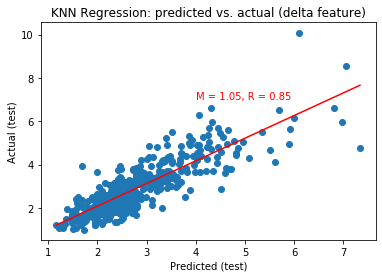

In [57]:
plt.scatter(KNN_pred_35, y_test)
plt.title('KNN Regression: predicted vs. actual (delta feature)', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(KNN_pred_35), np.poly1d(np.polyfit(KNN_pred_35, y_test, 1))(np.unique(KNN_pred_35)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(KNN_pred_35, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

#### Tune params 35

In [58]:
GS_CV = 10 # K-fold CV
K_min = 5 # Min K value
K_max = 50 # Max K value
K_inc = 5 # Increment in K search

KNNgrid_params = {
    'n_neighbors': np.array(range(K_min,K_max,K_inc)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
    'p': [1, 2, 3, 1000] }

KNNsearch_35 = GridSearchCV(neighbors.KNeighborsRegressor(), KNNgrid_params, cv=GS_CV)
KNNsearch_35.fit(X_train_scaled_35, y_train)
print('Optimal KNN paramaters:', KNNsearch_35.best_params_)


Optimal KNN paramaters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [59]:
# Refit using optimal paramaters
KNNopt_algorithm = KNNsearch_35.best_params_['algorithm']
KNNopt_metric = KNNsearch_35.best_params_['metric']
KNNopt_n_neighbors = KNNsearch_35.best_params_['n_neighbors']
KNNopt_p = KNNsearch_35.best_params_['p']
KNNopt_weights = KNNsearch_35.best_params_['weights']

KNNmodel_35 = neighbors.KNeighborsRegressor(algorithm = KNNopt_algorithm, metric=KNNopt_metric, 
                                            n_neighbors = KNNopt_n_neighbors, p=KNNopt_p, weights=KNNopt_weights)

KNNmodel_35.fit(X_train_scaled_35, y_train)  #fit the model

# Generate predictions to plot predicted and actuals
KNN_pred_35 = KNNmodel_35.predict(X_test_scaled_35)
KNNerrors_35 = abs(KNN_pred_35 - y_test)

# Calculate mean absolute percentage error (MAPE)
KNNmape_35 = 100 * (KNNerrors_35 / y_test)
KNNaccuracy_35 = 100 - np.mean(KNNmape_35)
print('Optimal K:', K_opt)
print('KNN accuracy (features=', X_train_35.shape[1],'):', round(KNNaccuracy_35, 2), '%.')
KNNtest_score_35 = KNNmodel_35.score(X_test_scaled_35, y_test)
print('KNN test score:', round(KNNtest_score_35, 3))


Optimal K: 5
KNN accuracy (features= 35 ): 85.34 %.
KNN test score: 0.742


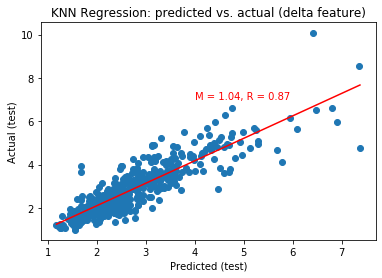

In [60]:
plt.scatter(KNN_pred_35, y_test)
plt.title('KNN Regression: predicted vs. actual (delta feature)', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(KNN_pred_35), np.poly1d(np.polyfit(KNN_pred_35, y_test, 1))(np.unique(KNN_pred_35)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(KNN_pred_35, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

#### Tune params 13

Optimal KNN paramaters: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Optimal K: 5
KNN accuracy (features= 13 ): 85.58 %.
KNN test score: 0.726


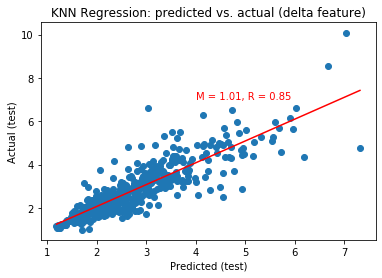

In [61]:
KNNsearch_13 = GridSearchCV(neighbors.KNeighborsRegressor(), KNNgrid_params, cv=GS_CV)
KNNsearch_13.fit(X_train_scaled_13, y_train)
print('Optimal KNN paramaters:', KNNsearch_13.best_params_)

# Refit using optimal paramaters
KNNopt_algorithm = KNNsearch_13.best_params_['algorithm']
KNNopt_metric = KNNsearch_13.best_params_['metric']
KNNopt_n_neighbors = KNNsearch_13.best_params_['n_neighbors']
KNNopt_p = KNNsearch_13.best_params_['p']
KNNopt_weights = KNNsearch_13.best_params_['weights']

KNNmodel_13 = neighbors.KNeighborsRegressor(algorithm = KNNopt_algorithm, metric=KNNopt_metric, 
                                            n_neighbors = KNNopt_n_neighbors, p=KNNopt_p, weights=KNNopt_weights)

KNNmodel_13.fit(X_train_scaled_13, y_train)  #fit the model

# Generate predictions to plot predicted and actuals
KNN_pred_13 = KNNmodel_13.predict(X_test_scaled_13)
KNNerrors_13 = abs(KNN_pred_13 - y_test)

# Calculate mean absolute percentage error (MAPE)
KNNmape_13 = 100 * (KNNerrors_13 / y_test)
KNNaccuracy_13 = 100 - np.mean(KNNmape_13)
print('Optimal K:', K_opt)
print('KNN accuracy (features=', X_train_13.shape[1],'):', round(KNNaccuracy_13, 2), '%.')
KNNtest_score_13 = KNNmodel_13.score(X_test_scaled_13, y_test)
print('KNN test score:', round(KNNtest_score_13, 3))

plt.scatter(KNN_pred_13, y_test)
plt.title('KNN Regression: predicted vs. actual (delta feature)', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(KNN_pred_13), np.poly1d(np.polyfit(KNN_pred_13, y_test, 1))(np.unique(KNN_pred_13)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(KNN_pred_13, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

### Artificial Neural Network

#### Use scaled 35

In [62]:
# Key variables
n_epochs = 1000 # iterations
ANNbatch = 100 # batches of training samples to propogate to optimise memory
ANN_CV = 10 #kfold CV

# Specify the keras model
def ANNbase_model():
    ANNmodel = Sequential()
    ANNmodel.add(Dense(28, input_dim=X_train_scaled_35.shape[1], activation='relu'))
    ANNmodel.add(Dense(24, kernel_initializer='random_uniform',bias_initializer='zeros', activation='relu'))
    ANNmodel.add(Dense(16, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(12, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(8, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(4, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(1, activation='linear'))

    # compile the keras model
    ANNmodel.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['accuracy'])
    
    return ANNmodel

# Evalate ANN
ANNestimator = KerasRegressor(build_fn=ANNbase_model, epochs=n_epochs, batch_size=ANNbatch, verbose=0)
ANNkfold = KFold(n_splits=ANN_CV)
ANNresults = cross_val_score(ANNestimator, X_scaled_35, y, cv=ANNkfold)
print("Baseline: %.2f (%.2f) MSE" % (ANNresults.mean(), ANNresults.std()))


Baseline: -24.64 (4.64) MSE


In [63]:
# Key variables
n_epochs = 1000 # iterations
ANNbatch = 100 # batches of training samples to propogate to optimise memory
ANN_CV = 10 #kfold CV

# Specify the keras model
def ANNbase_model():
    ANNmodel = Sequential()
    ANNmodel.add(Dense(128, input_dim=X_train_scaled_35.shape[1], activation='relu'))
    ANNmodel.add(Dense(64, kernel_initializer='random_uniform',bias_initializer='zeros', activation='relu'))
    ANNmodel.add(Dense(32, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(16, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(8, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(4, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(1, activation='linear'))

    # compile the keras model
    ANNmodel.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['accuracy'])
    
    return ANNmodel

# Evalate ANN
ANNestimator = KerasRegressor(build_fn=ANNbase_model, epochs=n_epochs, batch_size=ANNbatch, verbose=0)
ANNkfold = KFold(n_splits=ANN_CV)
ANNresults = cross_val_score(ANNestimator, X_scaled_35, y, cv=ANNkfold)
print("Baseline: %.2f (%.2f) MSE" % (ANNresults.mean(), ANNresults.std()))


Baseline: -24.72 (3.56) MSE


ANN accuracy (features= 35 ): 85.89 %.
ANN test score: -14.106


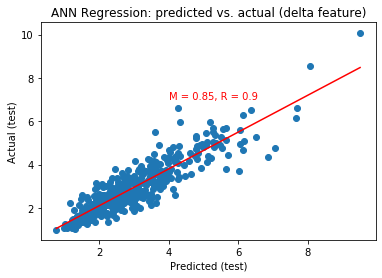

In [64]:
# Evaluate test acuracy
ANNestimator.fit(X_train_scaled_35, y_train)
ANN_pred_35 = ANNestimator.predict(X_test_scaled_35)
ANNerrors_35 = abs(ANN_pred_35 - y_test)

# Calculate mean absolute percentage error (MAPE)
ANNmape_35 = 100 * (ANNerrors_35 / y_test)
ANNaccuracy_35 = 100 - np.mean(ANNmape_35)
print('ANN accuracy (features=', X_train_scaled_35.shape[1],'):', round(ANNaccuracy_35, 2), '%.')
ANNtest_score_35 = ANNestimator.score(X_test_scaled_35, y_test)
print('ANN test score:', round(ANNtest_score_35, 3))

plt.scatter(ANN_pred_35, y_test)
plt.title('ANN Regression: predicted vs. actual (delta feature)', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(ANN_pred_35), np.poly1d(np.polyfit(ANN_pred_35, y_test, 1))(np.unique(ANN_pred_35)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ANN_pred_35, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()

### MLP

MLP accuracy (features= 35 ): 86.71 %.
MLP test score: 0.799


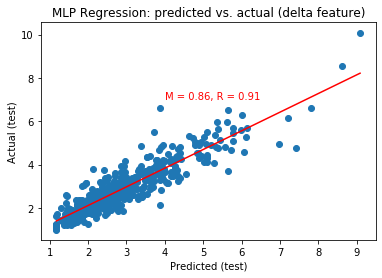

In [66]:
# Define MLP
MLPbatch = int(X_train_scaled_35.shape[0]/2)
MLPmodel_35 = MLPRegressor(hidden_layer_sizes=(256, 128, 64, 32, 16, 8, 4, 1), activation= 'relu', solver= 'lbfgs', 
                           alpha=1e-2, batch_size= MLPbatch, learning_rate= 'invscaling', learning_rate_init=1e-6, 
                           power_t=0.5, max_iter=10000, shuffle=True, random_state=None, tol=0.0001, 
                           verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, 
                           early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
                           epsilon=1e-10, n_iter_no_change=50)

MLPmodel_35.fit(X_train_scaled_35, y_train)
MLP_pred_35 = MLPmodel_35.predict(X_test_scaled_35)

MLPerrors_35 = abs(MLP_pred_35 - y_test)

# Calculate mean absolute percentage error (MAPE)
MLPmape_35 = 100 * (MLPerrors_35 / y_test)
MLPaccuracy_35 = 100 - np.mean(MLPmape_35)
print('MLP accuracy (features=', X_train_scaled_35.shape[1],'):', round(MLPaccuracy_35, 2), '%.')
MLPtest_score_35 = MLPmodel_35.score(X_test_scaled_35, y_test)
print('MLP test score:', round(MLPtest_score_35, 3))

plt.scatter(MLP_pred_35, y_test)
plt.title('MLP Regression: predicted vs. actual (delta feature)', fontsize=12)
plt.xlabel('Predicted (test)', fontsize=10)
plt.ylabel('Actual (test)', fontsize=10)

# Plot line of best fit
plt.plot(np.unique(MLP_pred_35), np.poly1d(np.polyfit(MLP_pred_35, y_test, 1))(np.unique(MLP_pred_35)), color='red')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(MLP_pred_35, y_test)
M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
plt.text(4,7,M_string, color='red')               
plt.show()
